### Importazione delle librerie
- La libreria `json` è utilizzata per esportare ed importare i parametri della rete neurale, come valori dei pesi, dei bias, valore $\eta$, ecc.
- La libreria `numpy` è utilizzata per svolgere calcoli e operazioni matematiche e lavorare con strutture quali vettori e matrici.
- La libreria `matplotlib.pyplot` è utilizzata per la rappresentazione di grafici. 

In [5]:
import json
import numpy as np
import matplotlib.pyplot as plt

### Creazione degli alias
Viene creato l'alias `vector` per il tipo `np.ndarray` definito dalla libreria `numpy`.

In [6]:
vector = np.ndarray

In [7]:
class NeuralNetwork:
    def __init__(self, input_size: int, hidden_size: int, output_size: int, eta: float=.01, momentum: float=.9): 
        # neural network architecture
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.eta = eta
        self.momentum = momentum
        
        # initialize neurons
        self.input_neurons = np.zeros((1, self.input_size))
        self.hidden_neurons = np.zeros((1, self.hidden_size))
        self.output_neurons = np.zeros((1, self.output_size))

        # weights for input -> hidden and for hidden -> output
        self.IH_weights = np.random.uniform(-1, 1, (self.input_size, self.hidden_size))
        self.HO_weights = np.random.uniform(-1, 1, (self.hidden_size, self.output_size))
        
        # bias for hidden and output layer
        self.HL_bias = np.zeros((1, self.hidden_size))
        self.OL_bias = np.zeros((1, self.output_size))
    
        # velocity terms for momentum
        self.IH_velocity = np.zeros_like(self.IH_weights)
        self.HO_velocity = np.zeros_like(self.HO_weights)
        self.HL_velocity = np.zeros_like(self.HL_bias)
        self.OL_velocity = np.zeros_like(self.OL_bias)

---
### Funzione sigmoidea
Funzione utilizzata come come funzione di attivazione nella rete neurale.

In [8]:
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

#### Derivata della funzione sigmoidea
Funzione che restituisce il valore della derivata della funzione sigmoidea, utilizzato nella backpropagation.

In [9]:
    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)

---
### Funzione di propagazione in avanti
La funzione riceve come parametro di input un vettore di input $X$.
In un'architettura di rete neurale con un singolo strato nascosto, le operazioni da effettuare sono:
1. Calcolo dell'input per l'hidden layer.
2. Applicazione della funzione di attivazione per l'hidden layer.
3. Calcolo dell'input per l'output layer.
4. Applicazione della funzione di attivazione per l'output layer.

#### Calcolo dell'input per l'hidden layer
$$Z_{hidden}=XW_{IH}+b_{hidden}$$

Dove:
- $W_{IH}$ è la matrice dei pesi che connettono l'input layer all'hidden layer di dimensione $(I\times H)$.
- $b_{hidden}$ è il vettore dei bias per l'hidden layer di dimensioni ($1 \times H$).
- $Z_{hidden}$ è l'input per i neuroni dell'hidden layer.

#### Applicazione della funzione di attivazione per l'hidden layer
Si applica la funzione sigmoidea per ottenere l'attivazione dell'hidden layer.
$$\sigma(z) = \frac{1}{1+e^{-Z_{hidden}}} $$

#### Calcolo dell'input per l'output layer
Analogamente al calcolo dell'input per l'hidden layer, si calcola l'input per l'output layer.
$$Z_{output}=A_{hidden}W_{HO}+b_{output}$$

Dove:
- $A_{hidden}$ è l'output dell'hidden layer.
- $W_{HO}$ è la matrice dei pesi che connettono l'hidden layer all'output layer di dimensione $(H\times O)$.
- $b_{output}$ è il vettore dei bias per l'output layer di dimensioni ($1 \times O$).
- $Z_{hidden}$ è l'output dell'output layer.

#### Applicazione della funzione di attivazione per l'output layer
Si applica nuovamente la funzione sigmoidea per ottenere l'attivazione dell'output layer.
$$\sigma(z) = \frac{1}{1+e^{-Z_{output}}} $$

In [10]:
def feedforward(self, X: vector) -> vector:
        # input -> hidden
        self.input_neurons = X
        self.hidden_input = np.dot(self.input_neurons, self.IH_weights) + self.HL_bias
        self.hidden_neurons = self.sigmoid(self.hidden_input)

        # hidden -> output
        self.output_input = np.dot(self.hidden_neurons, self.HO_weights) + self.OL_bias
        self.output_neurons = self.sigmoid(self.output_input)

        return self.output_neurons

#### Output finale
L'output finale è una matrice che rappresenta la probabilità per ciascun campione.

---
### Funzione di propagazione all'indietro
La backpropagation aggiorna i pesi e i bias per minimizzare l'errore tra l'output previsto y_{pred} e l'output reale y_{true}.

#### Calcolo dell'errore sull'output
L'errore ottenuto nell'output layer è ottenuto da:
$$E_{output} = y_{pred} - y_{true}$$

Dove:
- $E_{output}$ è l'errore dell'output layer.
- $y_{pred}$ è l'output ottenuto.
- $y_{true}$ è l'output reale.

L'errore è quindi pesato dalla derivata della funzione sigmoidea:
$$\delta_{output}=E_{output} \cdot \sigma'(Z_{output})$$
Dove:
$$\sigma'(Z_{output}) = \sigma(Z_{output}) \cdot (1 - \sigma(Z_{output}))$$

#### Propagazione dell'errore al layer nascosto
Si calcola quanto ogni neurone dell'hidden layer abbia contribuito all'errore dell'output layer e viene calcolato:
$$E_{hidden} = \delta_{output} \cdot W^{T}_{HO}$$
Dove:
- $W^{T}_{HO}$ è la matrice dei pesi tra l'hidden layer e l'output; viene trasposta in quanto si procede in direzione opposta al feedforward.
- $E_{hidden}$ è l'errore associato all'hidden layer.

Come per l'output, il termine $\delta_{hidden}$ è dato da:
$$\delta_{hidden}=E_{hidden} \cdot \sigma'(Z_{hidden})$$

#### Aggiornamento dei pesi e dei bias
La velocity è utilizzata quando si parla di **momentum** nelle reti neurali. Serve a migliorare la stabilità e la velocità di convergenza durante l'aggiornamento dei pesi.
##### Calcolo della velocity
La formula generale con il momentum è:
$$v_{t}=\mu \cdot v_{t-1}-\eta \cdot \frac{\partial L}{\partial W}$$

Dove:
- $v_{t}$ è la velocity al passo $t$ e rappresenta l'aggiornamento dei pesi combinato con il momento.
- $\mu$ è il fattore di momento.
- $v_{t-1}$ è la velocity del passo precedente.
- $\eta$ è il learning rate.
- $\frac{\partial L}{\partial W}$ è il gradiente della funzione di perdita rispetto ai pesi.

##### Aggiornamento dei pesi
I pesi vengono aggiornati usando la velocity calcolata:
$$W_{t} = W_{t-1}+v_{t}$$

##### Velocity e aggiornamento per i bias
Simile ai pesi, viene aggiornata una velocity separata per i bias $b$.

In [11]:
    def backpropagation(self, X: vector, y: vector) -> None:
        # get error at output layer
        output_error = self.output_neurons - y
        output_delta = output_error * self.sigmoid_derivative(self.output_input)

        # get error at hidden layer
        hidden_error = np.dot(output_delta, self.HO_weights.T)
        hidden_delta = hidden_error * self.sigmoid_derivative(self.hidden_input)

        # update weights and biases with momentum
        self.HO_velocity = self.momentum * self.HO_velocity - self.eta * np.dot(self.hidden_neurons.T, output_delta)
        self.HO_weights += self.HO_velocity

        self.OL_velocity = self.momentum * self.OL_velocity - self.eta * np.sum(output_delta, axis=0, keepdims=True)
        self.OL_bias += self.OL_velocity

        self.IH_velocity = self.momentum * self.IH_velocity - self.eta * np.dot(X.T, hidden_delta)
        self.IH_weights += self.IH_velocity

        self.HL_velocity = self.momentum * self.HL_velocity - self.eta * np.sum(hidden_delta, axis=0, keepdims=True)
        self.HL_bias += self.HL_velocity

---
### Funzione di perdita
Restituisce il valore di L'obiettivo è quello di minimizzare il valore di $L$.
$$L = \frac{\sum^{N}_{i=1}(y_{true}-y_{pred})^2}{N}$$
Dove:
- $y_{pred}$ è l'output ottenuto.
- $y_{true}$ è l'output reale.
- $N$ è il numero di campioni.

In [12]:
    def get_loss(self, y_true: vector, y_pred: vector) -> float:
        return np.mean((y_true - y_pred) ** 2)

---
### Funzione di avvio allenamento

In [13]:
    def train(self, X: vector, y: vector, epochs: int, debug: bool=False) -> None:
        loss = np.zeros(epochs)

        for i in range(epochs):
            self.feedforward(X)
            self.backpropagation(X, y)
            
            loss[i] = self.get_loss(y, self.output_neurons)
            
        if debug:
            for i in range(epochs):
                print(f"Epoch {i+1}/{epochs}, Loss: {loss[i]:.2f}")

            plt.figure(figsize=(8, 5))
            epochs = np.arange(len(loss))

            plt.plot(epochs, loss, label='Loss', marker='o', markersize=4)
            plt.title('Loss in function of epochs')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.grid(True)
            plt.legend()
            plt.show()

---
## Allenamento e test della rete neurale

In [48]:
import pandas as pd
import numpy as np
from NeuralNetwork import NeuralNetwork

### Caricamento del dataset
Il dataset `iris.data` viene caricato e assegnati i nomi alle colonne.

In [43]:
df = pd.read_csv("iris.data", header=None)
df.columns = ["Sepal length", "Sepal width", "Petal length", "Petal width", "Class"]

print(df[:5], "\n")

   Sepal length  Sepal width  Petal length  Petal width        Class
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa 



### Crezione del vettore delle feature
Il vettore $X$ contiene i valori numerici che verranno forniti in input alla rete neurale.

In [44]:
X = df[["Sepal length", "Sepal width", "Petal length", "Petal width"]].values
print(X[:5], "\n")

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]] 



### Crezione del vettore di output
Il vettore $y$ contiene i nomi delle specie, in formato one-hot encoded, corrispondenti a ciascun campione di dati.

In [45]:
y = pd.get_dummies(df["Class"]).values
print(y[:5], "\n")

[[ True False False]
 [ True False False]
 [ True False False]
 [ True False False]
 [ True False False]] 



### Divisione dei vettori di input e output per l'allenamento e il test
Per ogni specie viene utilizzato l'80% dei dati per l'allenamento e il restante 20% per il test della rete.

In [46]:
X_train = np.concatenate((X[:40], X[50:90], X[100:140]))
y_train = np.concatenate((y[:40], y[50:90], y[100:140]))
X_test = np.concatenate((X[40:50], X[90:100], X[140:150]))
y_test = np.concatenate((y[40:50], y[90:100], y[140:150]))

Epoch 1/100, Loss: 0.24
Epoch 2/100, Loss: 0.23
Epoch 3/100, Loss: 0.22
Epoch 4/100, Loss: 0.22
Epoch 5/100, Loss: 0.23
Epoch 6/100, Loss: 0.23
Epoch 7/100, Loss: 0.22
Epoch 8/100, Loss: 0.22
Epoch 9/100, Loss: 0.22
Epoch 10/100, Loss: 0.21
Epoch 11/100, Loss: 0.21
Epoch 12/100, Loss: 0.21
Epoch 13/100, Loss: 0.21
Epoch 14/100, Loss: 0.20
Epoch 15/100, Loss: 0.19
Epoch 16/100, Loss: 0.18
Epoch 17/100, Loss: 0.17
Epoch 18/100, Loss: 0.16
Epoch 19/100, Loss: 0.15
Epoch 20/100, Loss: 0.14
Epoch 21/100, Loss: 0.13
Epoch 22/100, Loss: 0.13
Epoch 23/100, Loss: 0.12
Epoch 24/100, Loss: 0.11
Epoch 25/100, Loss: 0.11
Epoch 26/100, Loss: 0.10
Epoch 27/100, Loss: 0.10
Epoch 28/100, Loss: 0.10
Epoch 29/100, Loss: 0.09
Epoch 30/100, Loss: 0.09
Epoch 31/100, Loss: 0.09
Epoch 32/100, Loss: 0.08
Epoch 33/100, Loss: 0.08
Epoch 34/100, Loss: 0.08
Epoch 35/100, Loss: 0.08
Epoch 36/100, Loss: 0.07
Epoch 37/100, Loss: 0.07
Epoch 38/100, Loss: 0.07
Epoch 39/100, Loss: 0.07
Epoch 40/100, Loss: 0.06
Epoch 41/

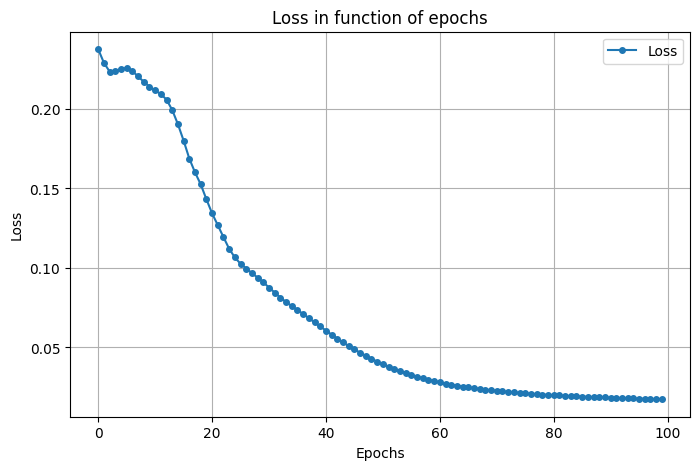

In [51]:
nn = NeuralNetwork(4, 8, 3, eta=.01, momentum=0.9)
nn.train(X=X_train, y=y_train, epochs=100, debug=True)

In [52]:
nn.test(X=X_test, y=y_test, debug=True)

96.56% that it is Iris-setosa. Actual: Iris-setosa. Result: True
95.1% that it is Iris-setosa. Actual: Iris-setosa. Result: True
96.4% that it is Iris-setosa. Actual: Iris-setosa. Result: True
96.16% that it is Iris-setosa. Actual: Iris-setosa. Result: True
95.87% that it is Iris-setosa. Actual: Iris-setosa. Result: True
96.11% that it is Iris-setosa. Actual: Iris-setosa. Result: True
96.38% that it is Iris-setosa. Actual: Iris-setosa. Result: True
96.27% that it is Iris-setosa. Actual: Iris-setosa. Result: True
96.44% that it is Iris-setosa. Actual: Iris-setosa. Result: True
96.37% that it is Iris-setosa. Actual: Iris-setosa. Result: True
78.72% that it is Iris-versicolor. Actual: Iris-versicolor. Result: True
88.75% that it is Iris-versicolor. Actual: Iris-versicolor. Result: True
93.38% that it is Iris-versicolor. Actual: Iris-versicolor. Result: True
93.95% that it is Iris-versicolor. Actual: Iris-versicolor. Result: True
89.08% that it is Iris-versicolor. Actual: Iris-versicolor. 

100.0